# Análisis del contenido - Plataforma Streaming

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import sys
import os

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
sys.path.append(project_root)

In [3]:
from plugins.helpers.my_utilities import get_db_engine

In [4]:
conn = get_db_engine()

In [5]:
# Configuración de estilo
plt.style.use('ggplot')
sns.set_palette("pastel")

#### Distribución de planes de suscripción

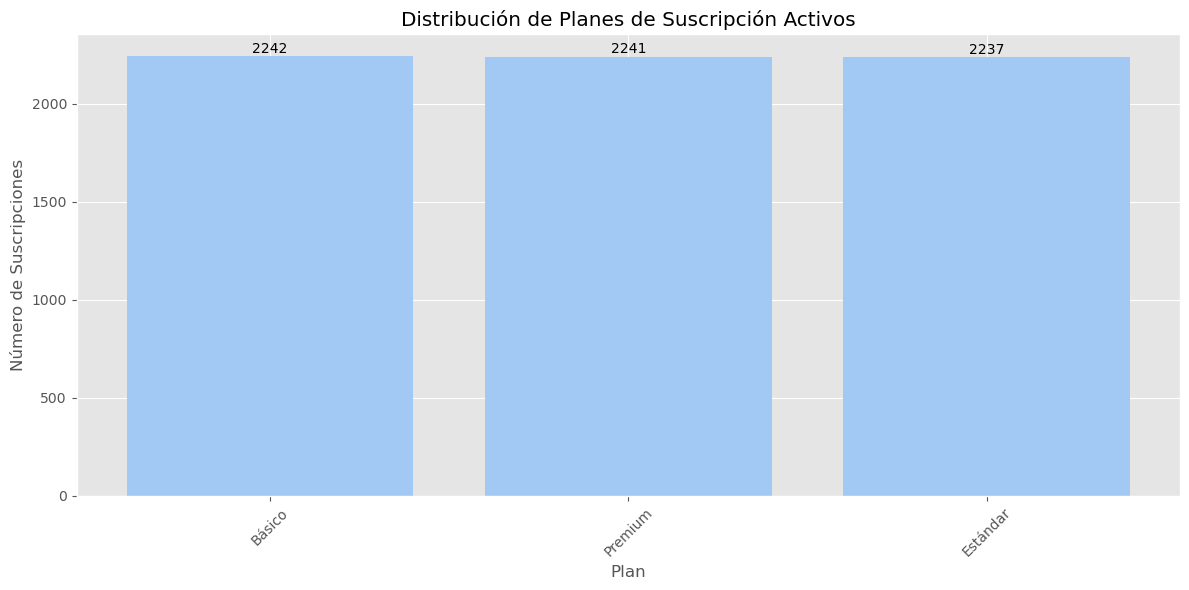

In [21]:
query_1 = """
SELECT 
    sp.name as plan_name,
    COUNT(s.subscription_id) as total_suscripciones,
    sp.price_monthly,
    sp.max_simultaneous_screens,
    sp.video_quality
FROM subscription_plans sp
LEFT JOIN subscriptions s ON sp.plan_id = s.plan_id
WHERE s.status = 'active'
GROUP BY sp.plan_id, sp.name, sp.price_monthly, sp.max_simultaneous_screens, sp.video_quality
ORDER BY total_suscripciones DESC;
"""

df_suscripciones = pd.read_sql(query_1, conn)

# Gráfico de distribución de planes
plt.figure(figsize=(12, 6))
bars = plt.bar(df_suscripciones['plan_name'], df_suscripciones['total_suscripciones'])
plt.title('Distribución de Planes de Suscripción Activos')
plt.xlabel('Plan')
plt.ylabel('Número de Suscripciones')
plt.xticks(rotation=45)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Contenido por género

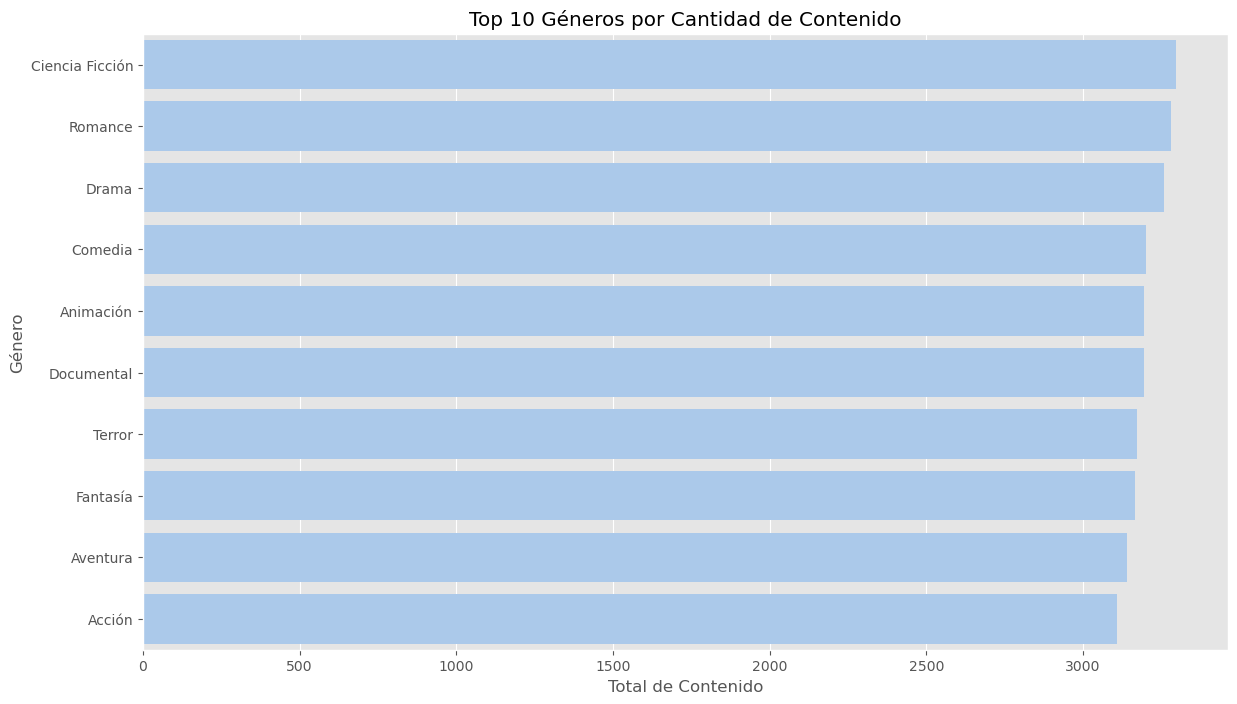

In [8]:
query_2 = """
SELECT 
    g.name as genero,
    COUNT(cg.content_id) as total_contenido,
    AVG(c.duration_minutes) as duracion_promedio,
    COUNT(DISTINCT CASE WHEN c.content_type = 'movie' THEN c.content_id END) as peliculas,
    COUNT(DISTINCT CASE WHEN c.content_type = 'series' THEN c.content_id END) as series
FROM genres g
JOIN content_genres cg ON g.genre_id = cg.genre_id
JOIN content c ON cg.content_id = c.content_id
GROUP BY g.name
ORDER BY total_contenido DESC;
"""

df_generos = pd.read_sql(query_2, conn)

# Gráfico de contenido por género
plt.figure(figsize=(14, 8))
sns.barplot(data=df_generos.head(10), x='total_contenido', y='genero')
plt.title('Top 10 Géneros por Cantidad de Contenido')
plt.xlabel('Total de Contenido')
plt.ylabel('Género')
plt.show()

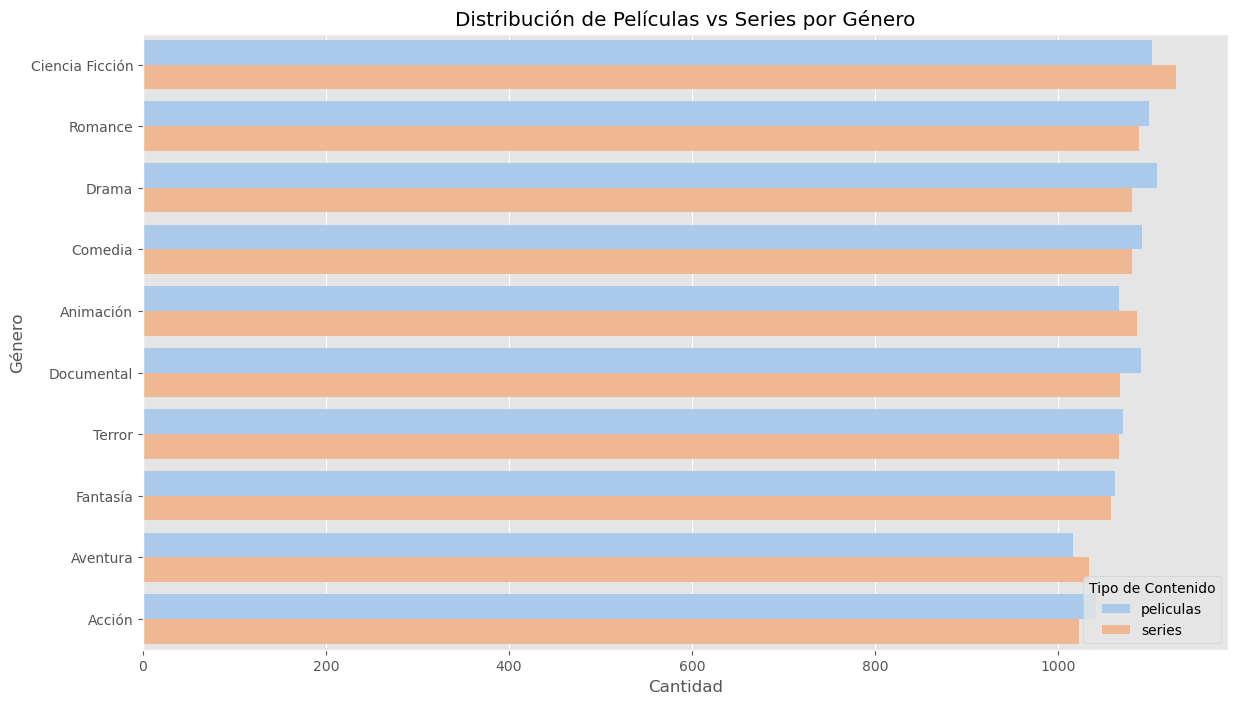

In [9]:
# Gráfico de proporción películas vs series por género
df_melted = df_generos.melt(id_vars=['genero'], value_vars=['peliculas', 'series'], 
                           var_name='tipo', value_name='cantidad')

plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted.head(20), x='cantidad', y='genero', hue='tipo')
plt.title('Distribución de Películas vs Series por Género')
plt.xlabel('Cantidad')
plt.ylabel('Género')
plt.legend(title='Tipo de Contenido')
plt.show()

#### Actividad de usuarios por hora del día

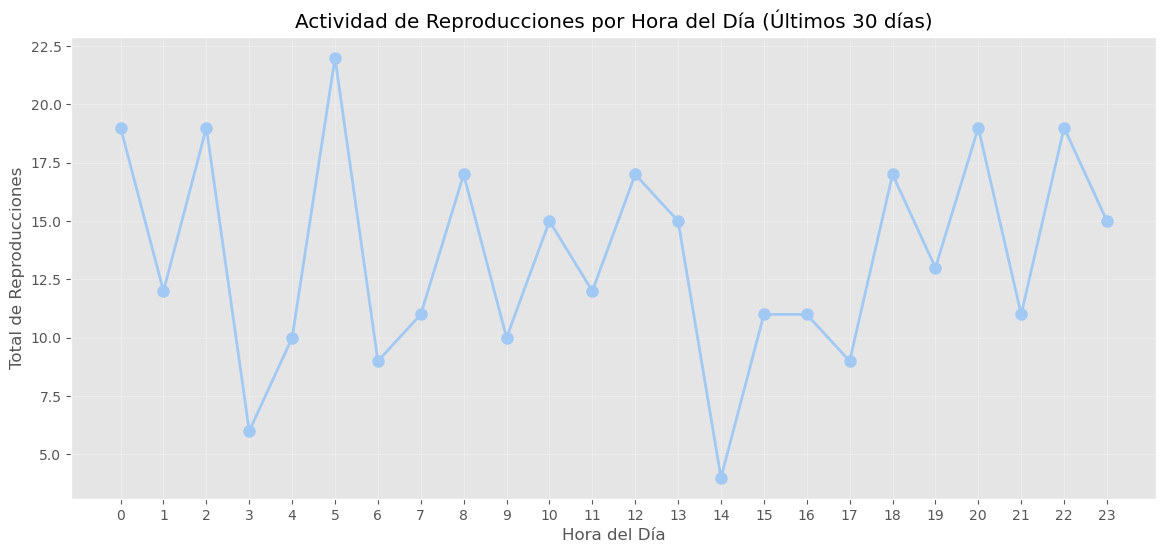

In [22]:
query_3 = """
SELECT 
    EXTRACT(HOUR FROM start_time) as hora,
    COUNT(play_id) as total_reproducciones,
    COUNT(DISTINCT user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (end_time - start_time))/60) as duracion_promedio_min
FROM plays
WHERE start_time >= CURRENT_DATE - INTERVAL '30 days'
GROUP BY EXTRACT(HOUR FROM start_time)
ORDER BY hora;
"""

df_actividad = pd.read_sql(query_3, conn)

# Gráfico de actividad por hora
plt.figure(figsize=(14, 6))
plt.plot(df_actividad['hora'], df_actividad['total_reproducciones'], marker='o', linewidth=2, markersize=8)
plt.title('Actividad de Reproducciones por Hora del Día (Últimos 30 días)')
plt.xlabel('Hora del Día')
plt.ylabel('Total de Reproducciones')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

#### Engagement por tipo de contenido

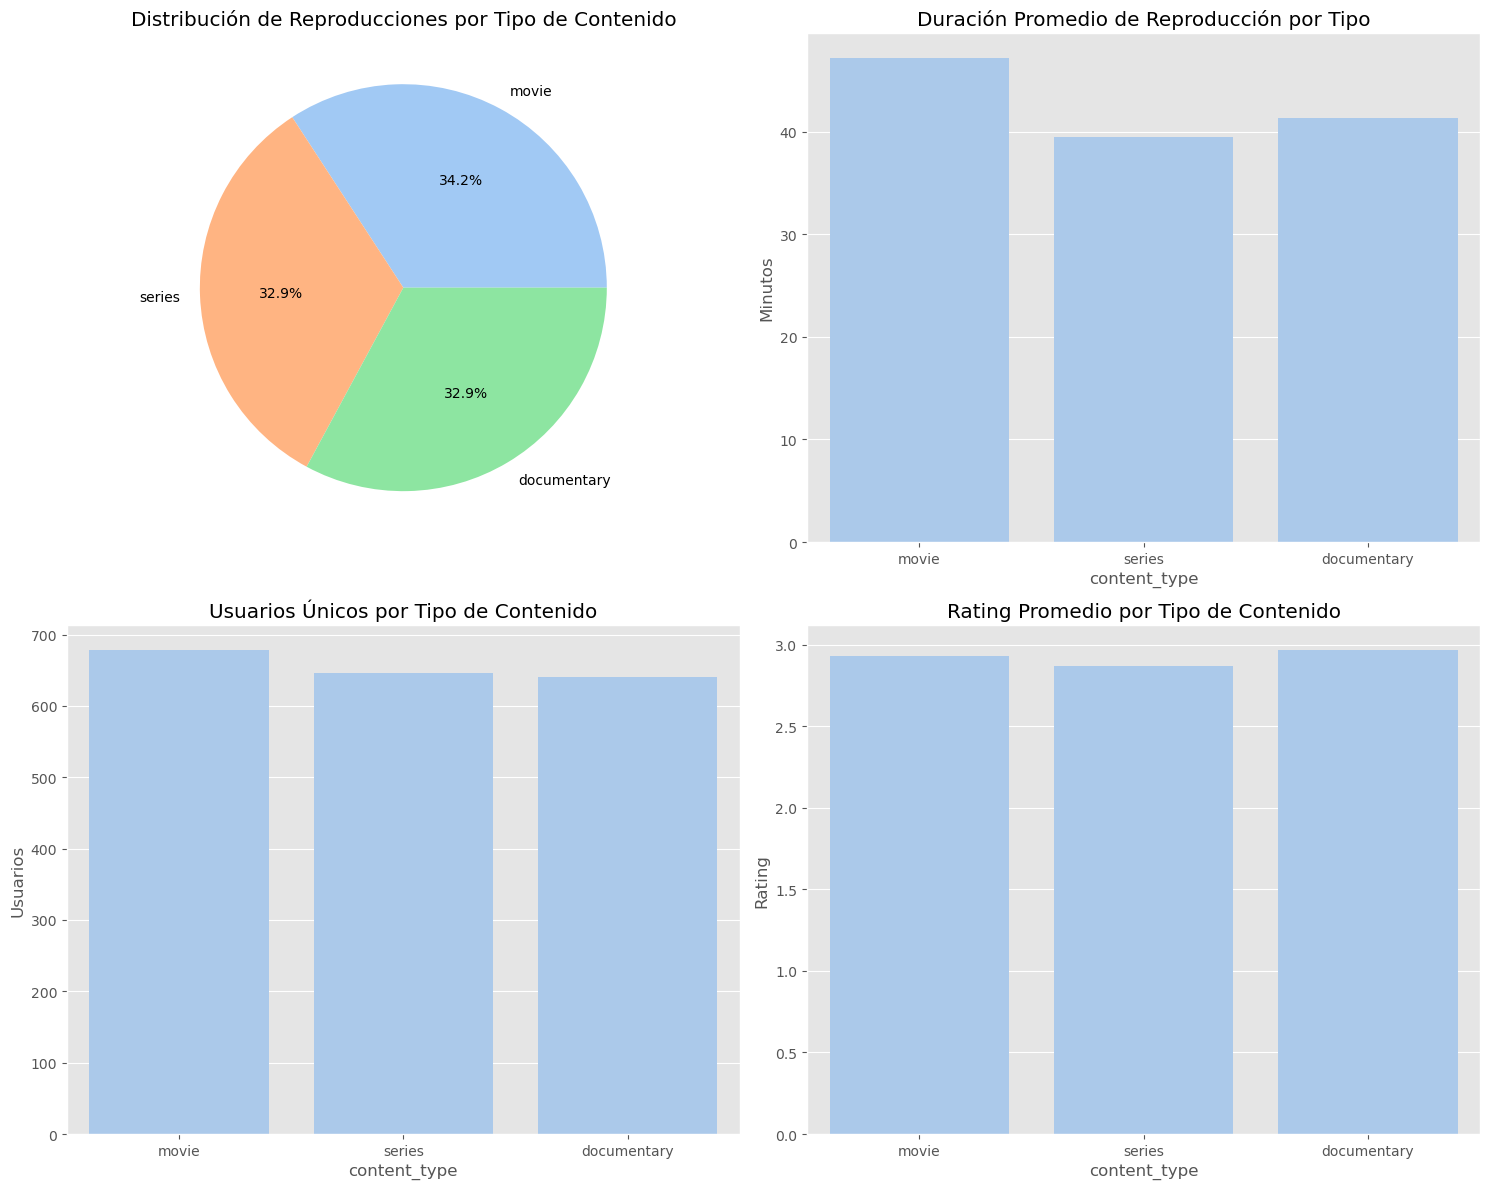

In [23]:
query_4 = """
SELECT 
    c.content_type,
    COUNT(p.play_id) as total_reproducciones,
    COUNT(DISTINCT p.user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (p.end_time - p.start_time))/60) as duracion_promedio_min,
    AVG(r.score) as rating_promedio
FROM content c
LEFT JOIN plays p ON c.content_id = p.content_id
LEFT JOIN ratings r ON c.content_id = r.content_id
WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
GROUP BY c.content_type
ORDER BY total_reproducciones DESC;
"""

df_engagement = pd.read_sql(query_4, conn)

# Gráfico de engagement
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Reproducciones por tipo
axes[0,0].pie(df_engagement['total_reproducciones'], labels=df_engagement['content_type'], autopct='%1.1f%%')
axes[0,0].set_title('Distribución de Reproducciones por Tipo de Contenido')

# Duración promedio
sns.barplot(data=df_engagement, x='content_type', y='duracion_promedio_min', ax=axes[0,1])
axes[0,1].set_title('Duración Promedio de Reproducción por Tipo')
axes[0,1].set_ylabel('Minutos')

# Usuarios únicos
sns.barplot(data=df_engagement, x='content_type', y='usuarios_unicos', ax=axes[1,0])
axes[1,0].set_title('Usuarios Únicos por Tipo de Contenido')
axes[1,0].set_ylabel('Usuarios')

# Rating promedio
sns.barplot(data=df_engagement, x='content_type', y='rating_promedio', ax=axes[1,1])
axes[1,1].set_title('Rating Promedio por Tipo de Contenido')
axes[1,1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

#### Crecimiento mensual de usuarios

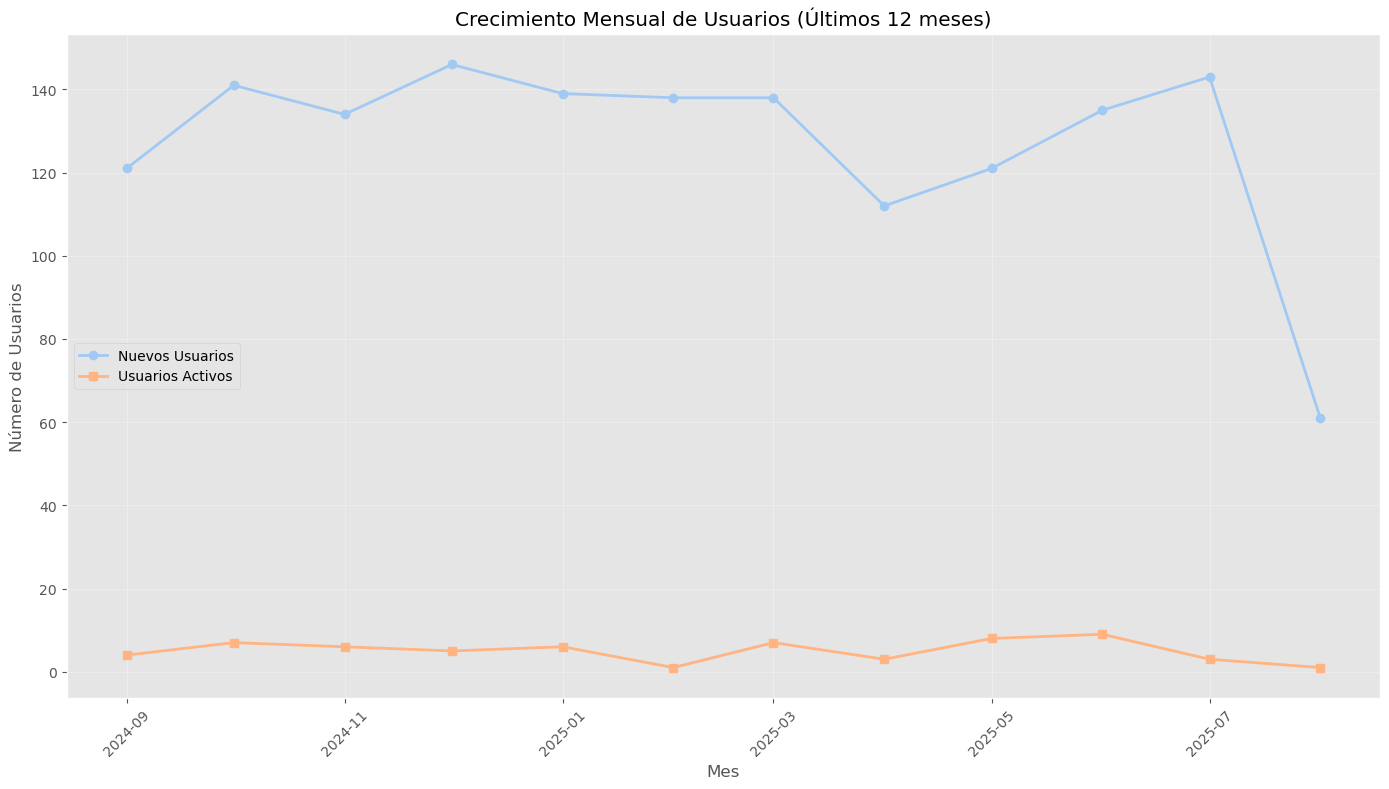

In [24]:
query_5 = """
SELECT 
    DATE_TRUNC('month', registration_date) as mes,
    COUNT(user_id) as nuevos_usuarios,
    COUNT(CASE WHEN last_login >= CURRENT_DATE - INTERVAL '30 days' THEN user_id END) as usuarios_activos
FROM users
WHERE registration_date >= CURRENT_DATE - INTERVAL '12 months'
GROUP BY DATE_TRUNC('month', registration_date)
ORDER BY mes;
"""

df_crecimiento = pd.read_sql(query_5, conn)
df_crecimiento['mes'] = pd.to_datetime(df_crecimiento['mes'])

# Gráfico de crecimiento
plt.figure(figsize=(14, 8))
plt.plot(df_crecimiento['mes'], df_crecimiento['nuevos_usuarios'], marker='o', label='Nuevos Usuarios', linewidth=2)
plt.plot(df_crecimiento['mes'], df_crecimiento['usuarios_activos'], marker='s', label='Usuarios Activos', linewidth=2)
plt.title('Crecimiento Mensual de Usuarios (Últimos 12 meses)')
plt.xlabel('Mes')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Uso de dispositivos

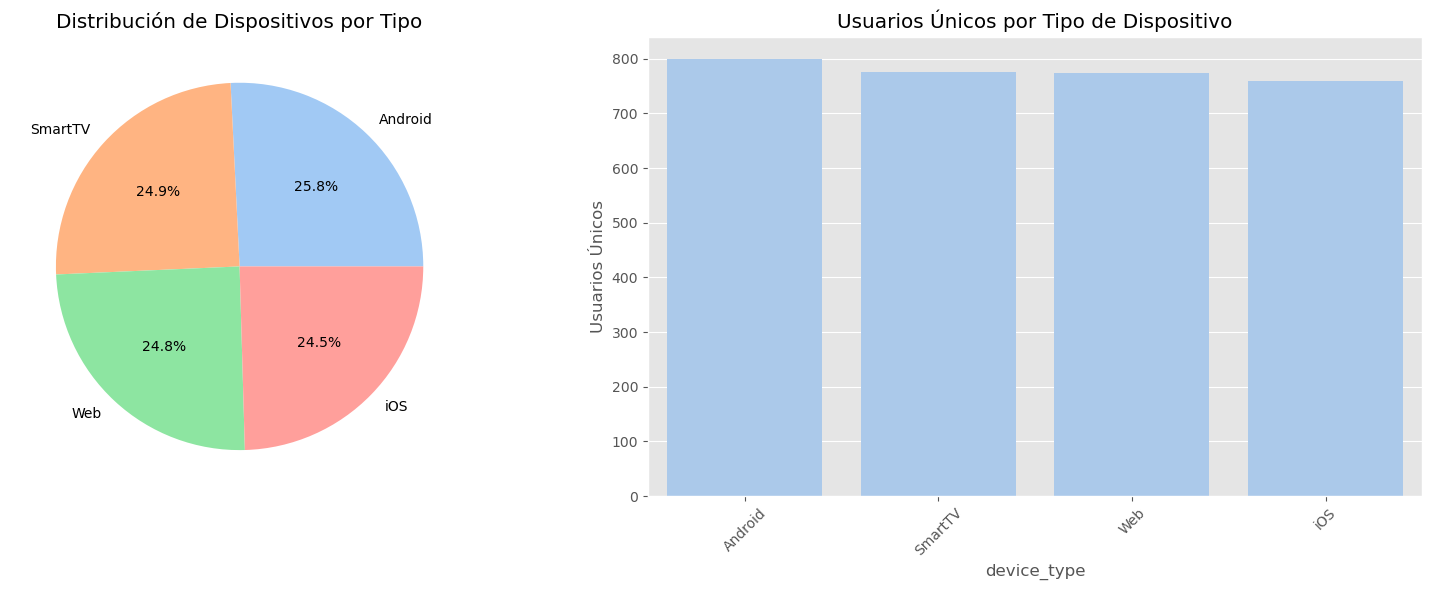

In [25]:
query_7 = """
SELECT 
    device_type,
    COUNT(device_id) as total_dispositivos,
    COUNT(DISTINCT user_id) as usuarios_unicos,
    AVG(EXTRACT(EPOCH FROM (CURRENT_TIMESTAMP - last_connection))/3600) as horas_desde_ultima_conexion
FROM devices
WHERE last_connection >= CURRENT_DATE - INTERVAL '90 days'
GROUP BY device_type
ORDER BY total_dispositivos DESC;
"""

df_dispositivos = pd.read_sql(query_7, conn)

# Gráfico de dispositivos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dispositivos por tipo
axes[0].pie(df_dispositivos['total_dispositivos'], labels=df_dispositivos['device_type'], autopct='%1.1f%%')
axes[0].set_title('Distribución de Dispositivos por Tipo')

# Actividad por dispositivo
sns.barplot(data=df_dispositivos, x='device_type', y='usuarios_unicos', ax=axes[1])
axes[1].set_title('Usuarios Únicos por Tipo de Dispositivo')
axes[1].set_ylabel('Usuarios Únicos')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

#### Ranking de contenido por género

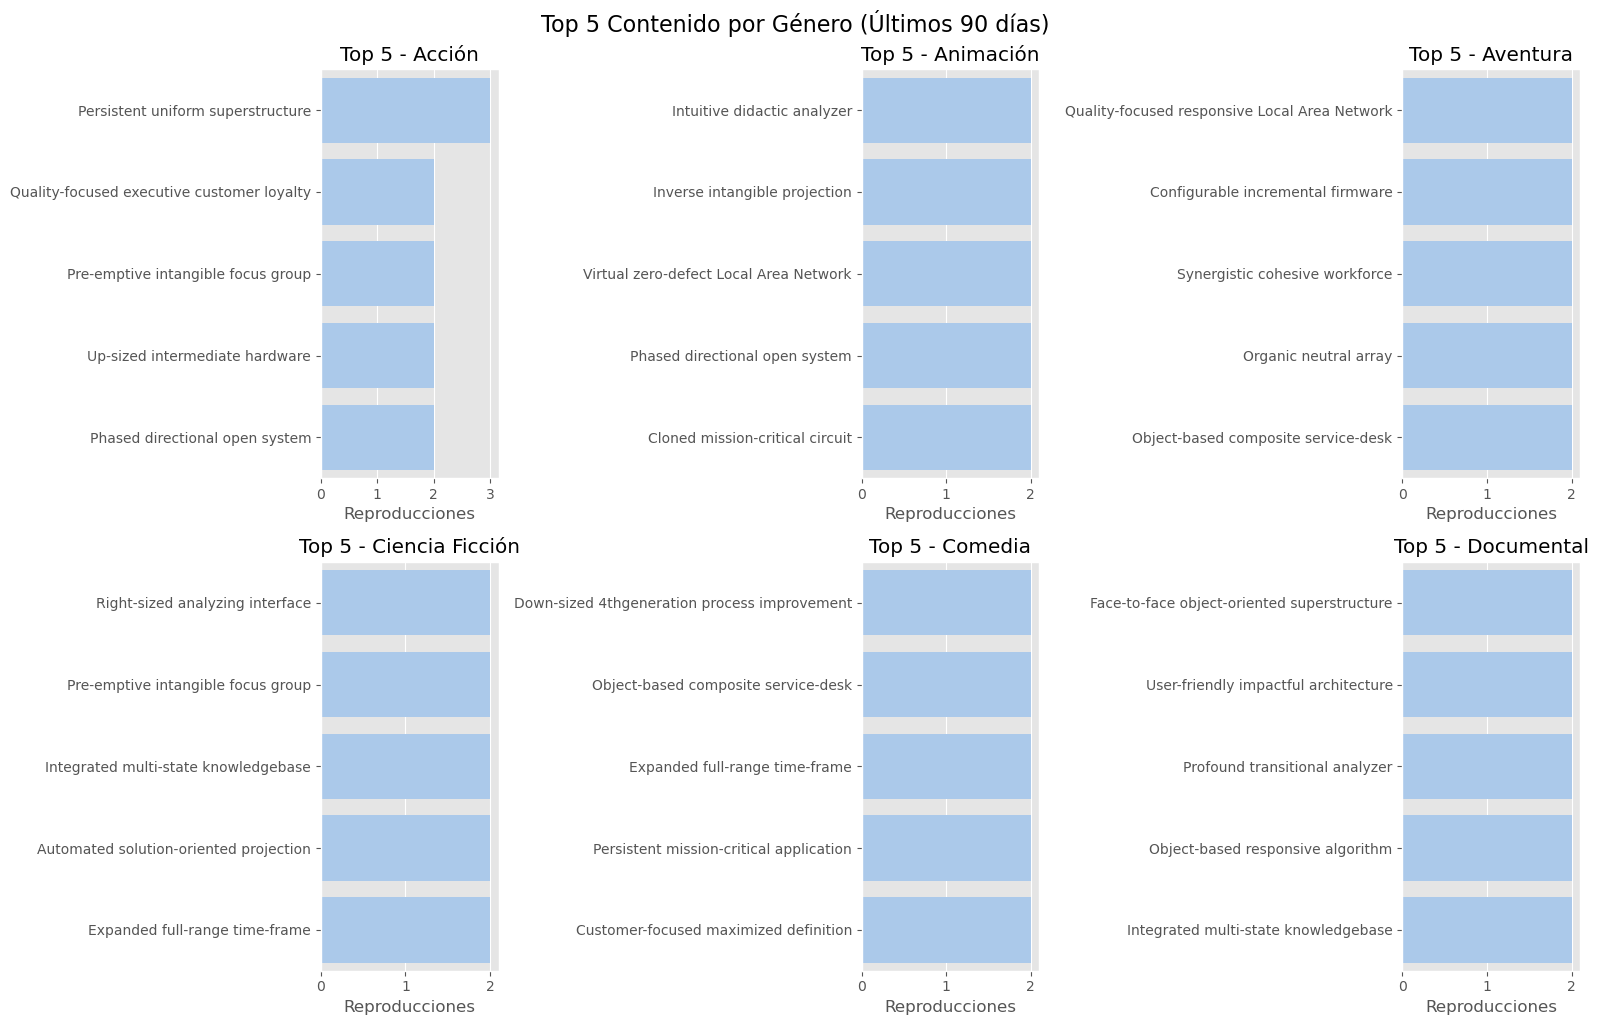

In [15]:
query_1 = """
WITH contenido_rank AS (
    SELECT 
        c.content_id,
        c.title,
        c.content_type,
        g.name as genero,
        COUNT(p.play_id) as total_reproducciones,
        ROW_NUMBER() OVER (PARTITION BY g.name ORDER BY COUNT(p.play_id) DESC) as ranking_genero,
        RANK() OVER (ORDER BY COUNT(p.play_id) DESC) as ranking_global
    FROM content c
    JOIN content_genres cg ON c.content_id = cg.content_id
    JOIN genres g ON cg.genre_id = g.genre_id
    LEFT JOIN plays p ON c.content_id = p.content_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
    GROUP BY c.content_id, c.title, c.content_type, g.name
)
SELECT *
FROM contenido_rank
WHERE ranking_genero <= 5
ORDER BY genero, ranking_genero;
"""

df_ranking_genero = pd.read_sql(query_1, conn)

# Gráfico de top contenido por género
plt.figure(figsize=(16, 10))
top_generos = df_ranking_genero['genero'].value_counts().index[:6]

for i, genero in enumerate(top_generos, 1):
    plt.subplot(2, 3, i)
    data = df_ranking_genero[df_ranking_genero['genero'] == genero].head(5)
    sns.barplot(data=data, x='total_reproducciones', y='title')
    plt.title(f'Top 5 - {genero}')
    plt.xlabel('Reproducciones')
    plt.ylabel('')
    plt.tight_layout()

plt.suptitle('Top 5 Contenido por Género (Últimos 90 días)', fontsize=16, y=1.02)
plt.show()

#### Tendencia de actividad mensual por usuario

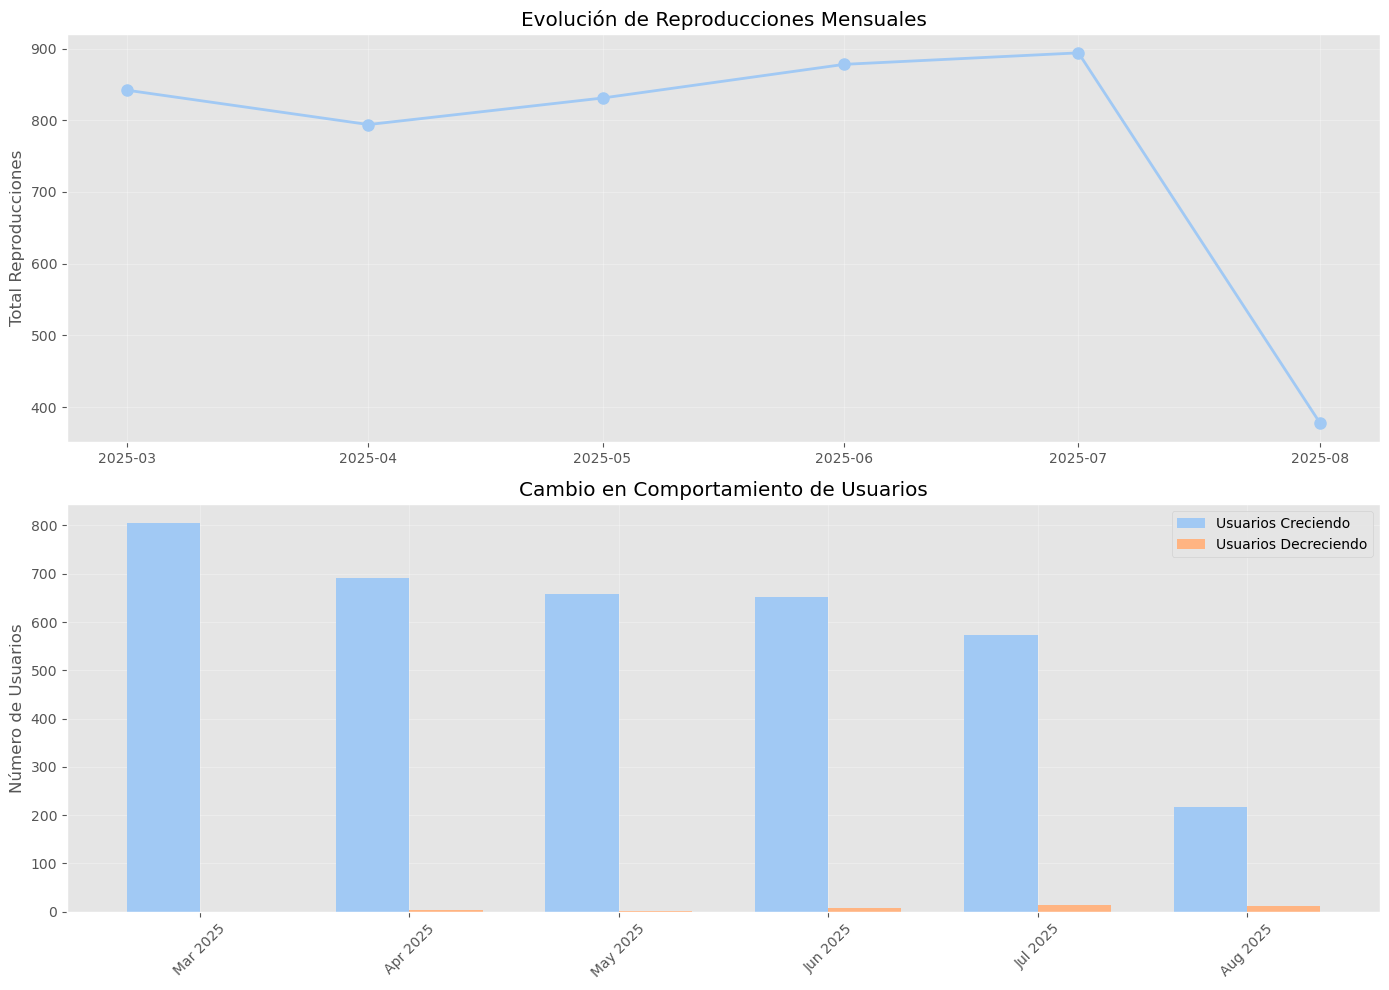

In [16]:
query_2 = """
WITH actividad_mensual AS (
    SELECT 
        u.user_id,
        u.name as usuario,
        DATE_TRUNC('month', p.start_time) as mes,
        COUNT(p.play_id) as reproducciones_mes,
        LAG(COUNT(p.play_id)) OVER (PARTITION BY u.user_id ORDER BY DATE_TRUNC('month', p.start_time)) as reproducciones_mes_anterior,
        LEAD(COUNT(p.play_id)) OVER (PARTITION BY u.user_id ORDER BY DATE_TRUNC('month', p.start_time)) as reproducciones_mes_siguiente
    FROM users u
    JOIN plays p ON u.user_id = p.user_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '6 months'
    GROUP BY u.user_id, u.name, DATE_TRUNC('month', p.start_time)
)
SELECT 
    mes,
    SUM(reproducciones_mes) as total_reproducciones,
    SUM(CASE WHEN reproducciones_mes > COALESCE(reproducciones_mes_anterior, 0) THEN 1 ELSE 0 END) as usuarios_creciendo,
    SUM(CASE WHEN reproducciones_mes < COALESCE(reproducciones_mes_anterior, 0) THEN 1 ELSE 0 END) as usuarios_decreciendo,
    AVG(reproducciones_mes) as promedio_reproducciones
FROM actividad_mensual
GROUP BY mes
ORDER BY mes;
"""

df_tendencia_usuarios = pd.read_sql(query_2, conn)
df_tendencia_usuarios['mes'] = pd.to_datetime(df_tendencia_usuarios['mes'])

# Gráfico de tendencia
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Total reproducciones
axes[0].plot(df_tendencia_usuarios['mes'], df_tendencia_usuarios['total_reproducciones'], 
            marker='o', linewidth=2, markersize=8)
axes[0].set_title('Evolución de Reproducciones Mensuales')
axes[0].set_ylabel('Total Reproducciones')
axes[0].grid(True, alpha=0.3)

# Usuarios creciendo/decreciendo
width = 0.35
x = np.arange(len(df_tendencia_usuarios))
axes[1].bar(x - width/2, df_tendencia_usuarios['usuarios_creciendo'], width, label='Usuarios Creciendo')
axes[1].bar(x + width/2, df_tendencia_usuarios['usuarios_decreciendo'], width, label='Usuarios Decreciendo')
axes[1].set_title('Cambio en Comportamiento de Usuarios')
axes[1].set_ylabel('Número de Usuarios')
axes[1].set_xticks(x)
axes[1].set_xticklabels([d.strftime('%b %Y') for d in df_tendencia_usuarios['mes']], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Tendencia de crecimiento con funciones

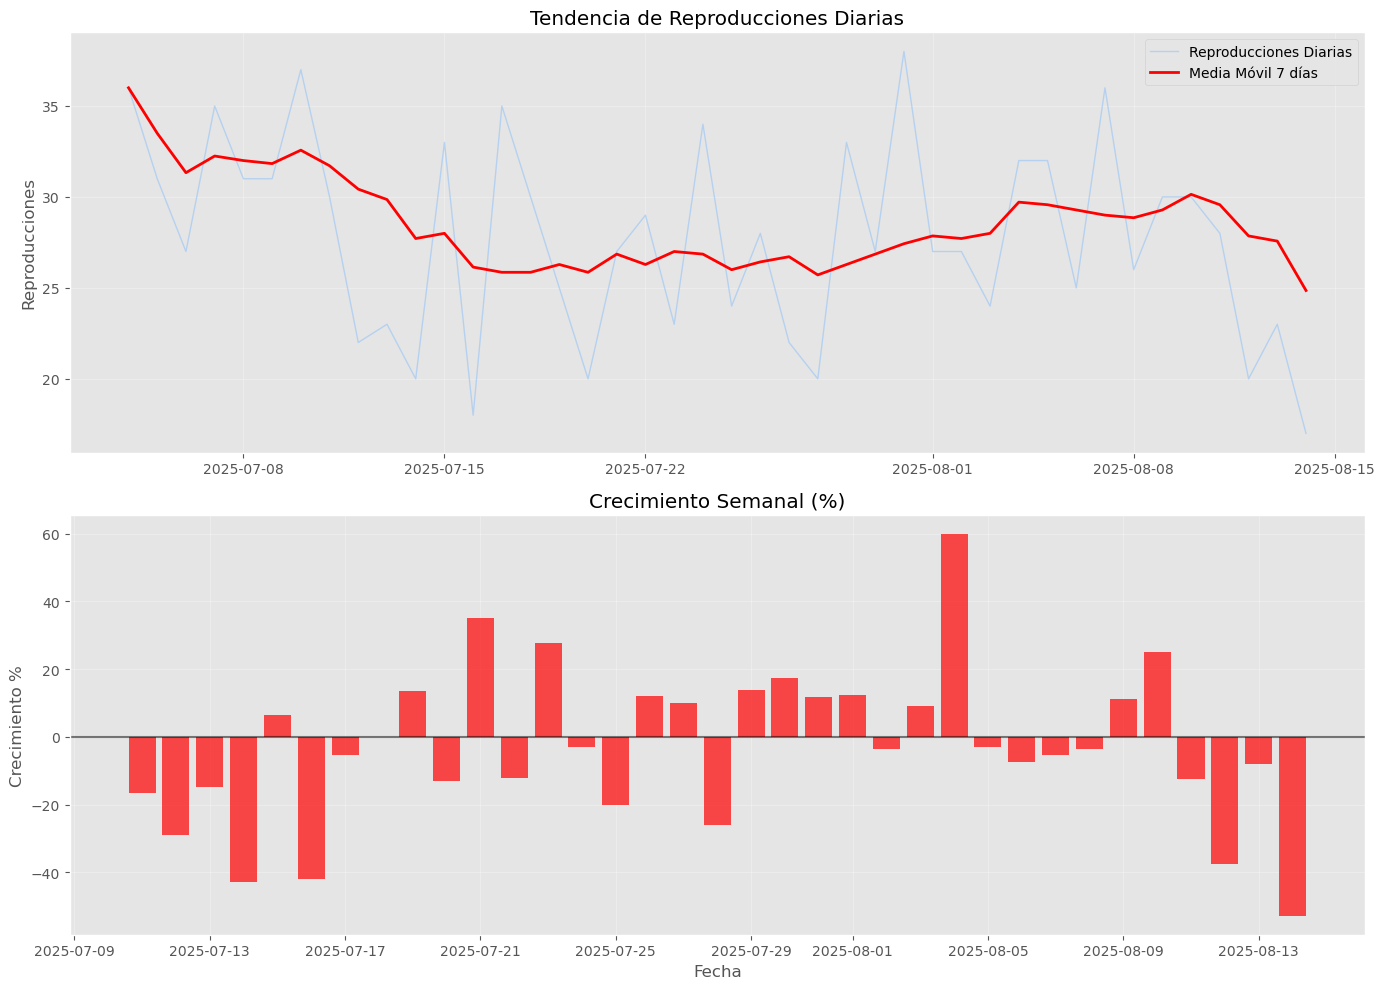

In [26]:
query_5 = """
WITH crecimiento_diario AS (
    SELECT 
        DATE_TRUNC('day', p.start_time) as fecha,
        COUNT(p.play_id) as reproducciones_dia,
        SUM(COUNT(p.play_id)) OVER (ORDER BY DATE_TRUNC('day', p.start_time)) as reproducciones_acumuladas,
        AVG(COUNT(p.play_id)) OVER (ORDER BY DATE_TRUNC('day', p.start_time) ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) as media_movil_7d,
        LAG(COUNT(p.play_id), 7) OVER (ORDER BY DATE_TRUNC('day', p.start_time)) as reproducciones_semana_anterior
    FROM plays p
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '60 days'
    GROUP BY DATE_TRUNC('day', p.start_time)
)
SELECT 
    fecha,
    reproducciones_dia,
    reproducciones_acumuladas,
    media_movil_7d,
    reproducciones_semana_anterior,
    (reproducciones_dia::float / reproducciones_semana_anterior - 1) * 100 as crecimiento_semanal
FROM crecimiento_diario
ORDER BY fecha;
"""

df_crecimiento_diario = pd.read_sql(query_5, conn)
df_crecimiento_diario['fecha'] = pd.to_datetime(df_crecimiento_diario['fecha'])

# Gráfico de tendencia temporal
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Reproducciones diarias y media móvil
axes[0].plot(df_crecimiento_diario['fecha'], df_crecimiento_diario['reproducciones_dia'], 
            label='Reproducciones Diarias', alpha=0.7, linewidth=1)
axes[0].plot(df_crecimiento_diario['fecha'], df_crecimiento_diario['media_movil_7d'], 
            label='Media Móvil 7 días', linewidth=2, color='red')
axes[0].set_title('Tendencia de Reproducciones Diarias')
axes[0].set_ylabel('Reproducciones')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Crecimiento semanal
axes[1].bar(df_crecimiento_diario['fecha'], df_crecimiento_diario['crecimiento_semanal'], 
           alpha=0.7, color='green' if df_crecimiento_diario['crecimiento_semanal'].iloc[-1] > 0 else 'red')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Crecimiento Semanal (%)')
axes[1].set_ylabel('Crecimiento %')
axes[1].set_xlabel('Fecha')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Comportamiento de usuarios nuevos vs existentes

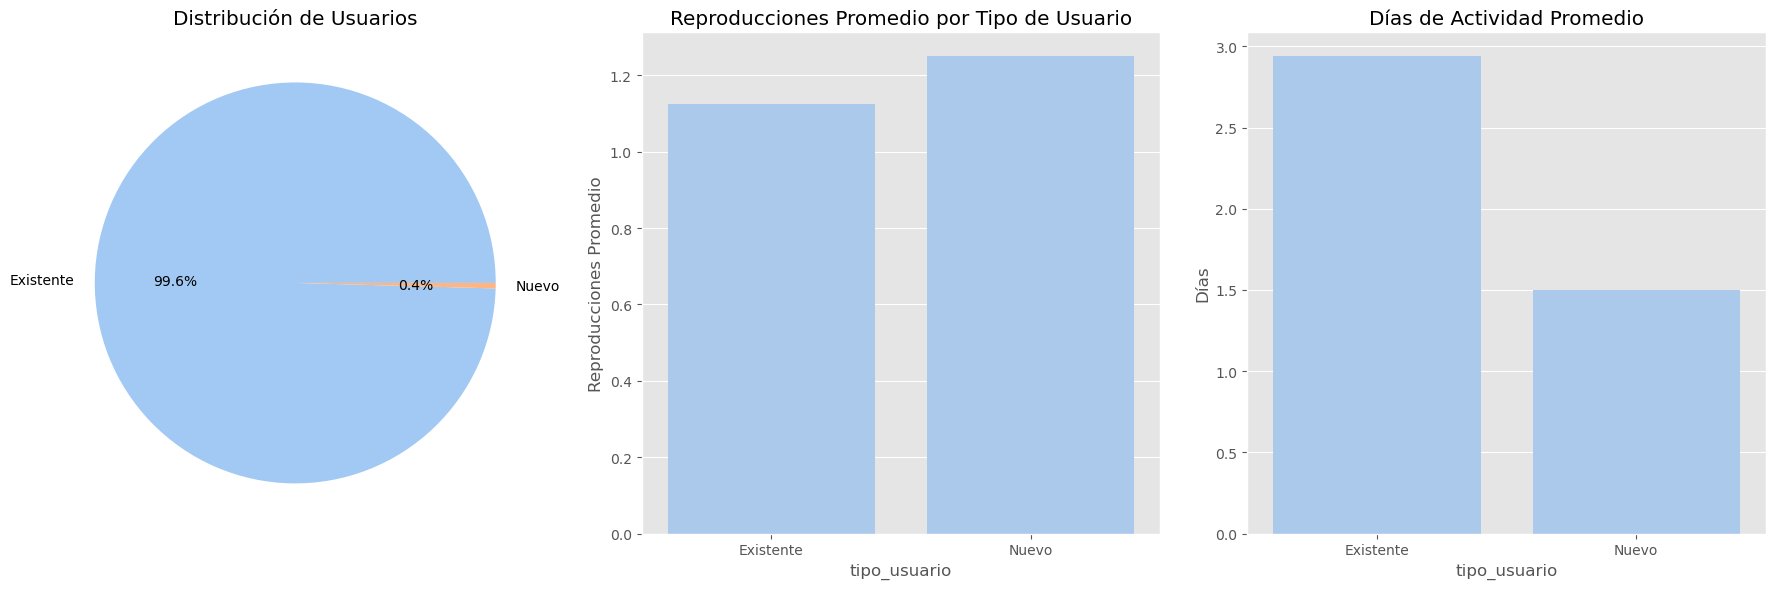

In [27]:
query_6 = """
WITH actividad_usuario AS (
    SELECT 
        u.user_id,
        u.registration_date,
        FIRST_VALUE(p.start_time) OVER (PARTITION BY u.user_id ORDER BY p.start_time) as primera_reproduccion,
        LAST_VALUE(p.start_time) OVER (PARTITION BY u.user_id ORDER BY p.start_time ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as ultima_reproduccion,
        COUNT(p.play_id) OVER (PARTITION BY u.user_id) as total_reproducciones
    FROM users u
    JOIN plays p ON u.user_id = p.user_id
    WHERE p.start_time >= CURRENT_DATE - INTERVAL '90 days'
),
usuario_stats AS (
    SELECT DISTINCT
        user_id,
        registration_date,
        primera_reproduccion,
        ultima_reproduccion,
        total_reproducciones,
        (ultima_reproduccion - primera_reproduccion) as periodo_actividad,
        CASE 
            WHEN registration_date >= CURRENT_DATE - INTERVAL '30 days' THEN 'Nuevo'
            ELSE 'Existente'
        END as tipo_usuario
    FROM actividad_usuario
)
SELECT 
    tipo_usuario,
    COUNT(user_id) as total_usuarios,
    AVG(total_reproducciones) as reproducciones_promedio,
    AVG(EXTRACT(EPOCH FROM periodo_actividad)/86400) as dias_actividad_promedio,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_reproducciones) as mediana_reproducciones
FROM usuario_stats
GROUP BY tipo_usuario;
"""

df_comportamiento_usuarios = pd.read_sql(query_6, conn)

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total usuarios
axes[0].pie(df_comportamiento_usuarios['total_usuarios'], 
           labels=df_comportamiento_usuarios['tipo_usuario'], 
           autopct='%1.1f%%')
axes[0].set_title('Distribución de Usuarios')

# Reproducciones promedio
sns.barplot(data=df_comportamiento_usuarios, x='tipo_usuario', y='reproducciones_promedio', ax=axes[1])
axes[1].set_title('Reproducciones Promedio por Tipo de Usuario')
axes[1].set_ylabel('Reproducciones Promedio')

# Días de actividad
sns.barplot(data=df_comportamiento_usuarios, x='tipo_usuario', y='dias_actividad_promedio', ax=axes[2])
axes[2].set_title('Días de Actividad Promedio')
axes[2].set_ylabel('Días')

plt.tight_layout()
plt.show()